In [45]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

os.chdir('/data/yosef2/users/chenling/HarmonizationSCANVI')
save_path = "../symsim_scVI/symsim_result/DE/"


In [46]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [47]:
nevf = pd.read_csv(os.path.join(save_path, "n_evf.csv"),
                             sep=",", index_col=0, header=0)
nevf=np.asarray(nevf['x'])

In [48]:
def eval_de(log_fold_change, logFC):
    """
    :param log_fold_change: groundtruth
    :param bayes_f: non-log Bayes Factor
    :return:
    """
    auc_1 = roc_auc_score(np.abs(log_fold_change) >= 0.6, np.abs(logFC))
    auc_2 = roc_auc_score(np.abs(log_fold_change) >= 0.8, np.abs(logFC))
    spear = spearmanr(logFC, log_fold_change)
    kend = kendalltau(logFC, log_fold_change)
    return auc_1, auc_2, spear[0], kend[0]


In [49]:
def eval_de(log_fold_change, logFC):
    """
    :param log_fold_change: groundtruth
    :param bayes_f: non-log Bayes Factor
    :return:
    """
    auc_1 = roc_auc_score(np.abs(log_fold_change) >= 0.6, np.abs(logFC))
    auc_2 = roc_auc_score(np.abs(log_fold_change) >= 0.8, np.abs(logFC))
    spear = spearmanr(logFC, log_fold_change)
    kend = kendalltau(logFC, log_fold_change)
    return auc_1, auc_2, spear[0], kend[0]


In [51]:
# compute average classification accuracy 
truelab = np.genfromtxt(save_path + 'DE.obsv.labels.csv',)
batch = np.genfromtxt(save_path + 'DE.obsv.batch.csv',)
scvi = []
scanvi=[]
for prop in [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
# for prop in [ 0.10]:
#     for i in [1,2]:
    for i in range(10):
        pred = pd.read_csv(save_path + 'SIM.pred_labels.%i.mis%.2f.csv'%((i+1),prop))
        scvi_pred = np.asarray(pred['scVI'])
        scvi.append([np.mean(scvi_pred==truelab),
            np.mean(scvi_pred[batch==0]==truelab[batch==0]),
            np.mean(scvi_pred[batch==1]==truelab[batch==1])])
        scanvi_pred = np.asarray(pred['scANVI'])
        scanvi.append([np.mean(scanvi_pred==truelab),
            np.mean(scanvi_pred[batch==0]==truelab[batch==0]),
            np.mean(scanvi_pred[batch==1]==truelab[batch==1])])
    print('SCVI')
    mean = np.asarray(scvi).mean(axis=0)
    std = np.asarray(scvi).std(axis=0)
    for i in range(2):
        print('for %.2f mislabelled cells, average accuracy = %.3f±%.3f' % (prop, mean[i],std[i]))
    print('scANVI')
    mean = np.asarray(scanvi).mean(axis=0)
    std = np.asarray(scanvi).std(axis=0)
    for i in range(2):
        print('for %.2f mislabelled cells, average accuracy = %.3f±%.3f' % (prop, mean[i],std[i]))





SCVI
for 0.05 mislabelled cells, average accuracy = 0.897±0.002
for 0.05 mislabelled cells, average accuracy = 0.909±0.002
scANVI
for 0.05 mislabelled cells, average accuracy = 0.911±0.002
for 0.05 mislabelled cells, average accuracy = 0.920±0.002
SCVI
for 0.10 mislabelled cells, average accuracy = 0.896±0.002
for 0.10 mislabelled cells, average accuracy = 0.908±0.002
scANVI
for 0.10 mislabelled cells, average accuracy = 0.912±0.001
for 0.10 mislabelled cells, average accuracy = 0.920±0.002
SCVI
for 0.15 mislabelled cells, average accuracy = 0.894±0.004
for 0.15 mislabelled cells, average accuracy = 0.907±0.003
scANVI
for 0.15 mislabelled cells, average accuracy = 0.911±0.001
for 0.15 mislabelled cells, average accuracy = 0.920±0.002
SCVI
for 0.20 mislabelled cells, average accuracy = 0.892±0.005
for 0.20 mislabelled cells, average accuracy = 0.904±0.005
scANVI
for 0.20 mislabelled cells, average accuracy = 0.911±0.002
for 0.20 mislabelled cells, average accuracy = 0.919±0.002
SCVI
for

In [52]:
theoretical_FC = pd.read_csv(os.path.join(save_path, "theoreticalFC.csv"),
                             sep=",", index_col=0, header=0)
nevf = pd.read_csv(os.path.join(save_path, "n_evf.csv"),
                             sep=",", index_col=0, header=0)


In [55]:
scvires={'bayes_A':{},'bayes_B':{},'bayes_AB':{},'bayes_scanviAB':{}}
for type in ['bayes_A','bayes_B','bayes_AB','bayes_scanviAB']:
    scvires[type] = {'12':{},'23':{},'24':{},'45':{}}
    for comparison in ['12','23','24','45']:
        scvires[type][comparison] = {}
        for prop in [ 0.00,0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
#         for prop in [ 0.10]:
            scvires[type][comparison][prop]=[]
            scvires[type][comparison][prop] = {'R1':[],'R2':[],'S':[],'K':[]}
            for rep in range(10):
#             for rep in [0,1]:
                X = pd.read_csv(os.path.join(save_path,'SIM.result.%s.%i.mis%.2f.csv'%(comparison,rep+1,prop)))
                X = X[type]
                X = np.log(X + 1e-8) - np.log(1 - X + 1e-8)
                stats = eval_de(theoretical_FC[comparison], X)
                for i,x in enumerate(['R1','R2','S','K']):
                    scvires[type][comparison][prop][x].append(stats[i])


In [61]:
edgeR_res={}
for prop in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
    edgeR_res[prop] = {'12':{},'23':{},'24':{},'45':{}}
    for comparison in ['12','23','24','45']:
        edgeR_res[prop][comparison] = {'A': {}, 'B': {}, 'AB': {}}
        for batch in ['A', 'B', 'AB']:
            edgeR_res[prop][comparison][batch] = {'R1':[],'R2':[],'S':[],'K':[]}
            for rep in range(10):
                X = pd.read_csv(os.path.join(save_path, 'EdgeR/SIM.%s.%i.%.2f.%s.edgeR.csv') % (batch, (rep+1), prop, comparison))
                stats = eval_de(theoretical_FC[comparison], X['logFC'])
                for i,x in enumerate(['R1','R2','S','K']):
                    edgeR_res[prop][comparison][batch][x].append(np.abs(stats[i]))


In [75]:
edgeR_res_p={}
for prop in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
    edgeR_res_p[prop] = {'12':{},'23':{},'24':{},'45':{}}
    for comparison in ['12','23','24','45']:
        edgeR_res_p[prop][comparison] = {'A': {}, 'B': {}, 'AB': {}}
        for batch in ['A', 'B', 'AB']:
            edgeR_res_p[prop][comparison][batch] = {'R1':[],'R2':[],'S':[],'K':[]}
            for rep in range(10):
                X = pd.read_csv(os.path.join(save_path, 'EdgeR/SIM.%s.%i.%.2f.%s.edgeR.csv') % (batch, (rep+1), prop, comparison))
                stats = eval_de(np.abs(theoretical_FC[comparison]), -np.log(X['PValue']))
                for i,x in enumerate(['R1','R2','S','K']):
                    edgeR_res_p[prop][comparison][batch][x].append(np.abs(stats[i]))


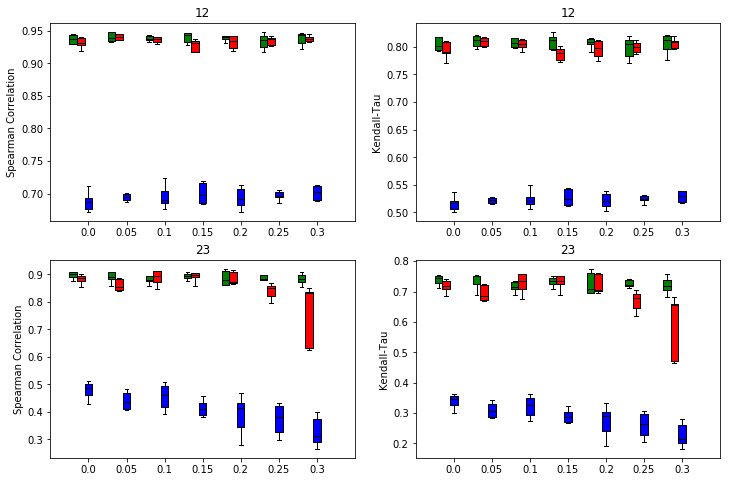

In [62]:
# measure_names = ['AUC1','AUC2','Spearman','Kendall']
measure_names = ['Spearman Correlation','Kendall-Tau']
plt.figure(figsize=(12, 8))
# for name, measure in enumerate(['R1', 'R2', 'S', 'K']): 
for name, measure in enumerate([ 'S', 'K']): 
    for row,comparison in enumerate(['12','23']):
        props = dict(widths=0.1, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")
        #AUC CD$CD*
        ax = plt.subplot(2, 2, row*2+name+1)
        ax.set_ylabel(measure_names[name])
        plt.title(comparison)
        bp1 = ax.boxplot([scvires['bayes_scanviAB'][comparison][prop][measure]
                          for prop in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], 
                         positions=[x*10 for x in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], **props)

        bp2 = ax.boxplot([scvires['bayes_AB'][comparison][prop][measure]
                  for prop in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], 
                 positions=[(x*10+0.1) for x in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], **props)

        bp3 = ax.boxplot([edgeR_res[prop][comparison][batch][measure]
                  for prop in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], 
                 positions=[(x*10+0.2) for x in [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]], **props)

        for patch in bp1['boxes']:
            patch.set_facecolor('green')
        for patch in bp2['boxes']:
            patch.set_facecolor('red')
        for patch in bp3['boxes']:
            patch.set_facecolor('blue')

        ax.set_xticklabels([ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
#         ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]] ,['scANVI', 'scVI', 'Seurat'])

plt.savefig('SIM.DEmislabelled.pdf')

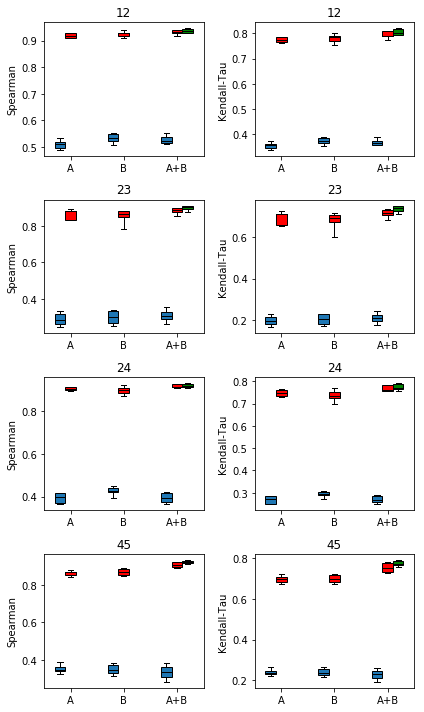

In [77]:
measure_names = ['Spearman','Kendall-Tau']
plt.figure(figsize=(6, 10))
for name, measure in enumerate(['S', 'K']): 
    for row,comparison in enumerate(['12','23','24','45']):
        props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

        #AUC CD$CD*
        ax = plt.subplot(4, 2, row*2+name+1)
        ax.set_ylabel(measure_names[name])
#         ax.set_ylabel(comparison)
        plt.title(comparison)
        bp1 = ax.boxplot([np.abs(edgeR_res_p[0.0][comparison][x][measure]) for x in ['A','B','AB'] ], positions=[0, 1, 2], **props)
        bp2 = ax.boxplot([scvires['bayes_scanviAB'][comparison][0.0][measure]], positions=[2.4], **props)
        bp3 = ax.boxplot([scvires[x][comparison][0.0][measure] for x in ['bayes_A','bayes_B','bayes_AB']], positions=[0.2, 1.2, 2.2], **props)

        for patch in bp3['boxes']:
            patch.set_facecolor('red')
        for patch in bp2['boxes']:
            patch.set_facecolor('green')

        ax.set_xticklabels(['A','B', 'A+B'])

# ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['edgeR', 'SCANVI', 'scVI'])
plt.tight_layout()
plt.savefig('SIM.DE.edgeRpvalue.pdf')

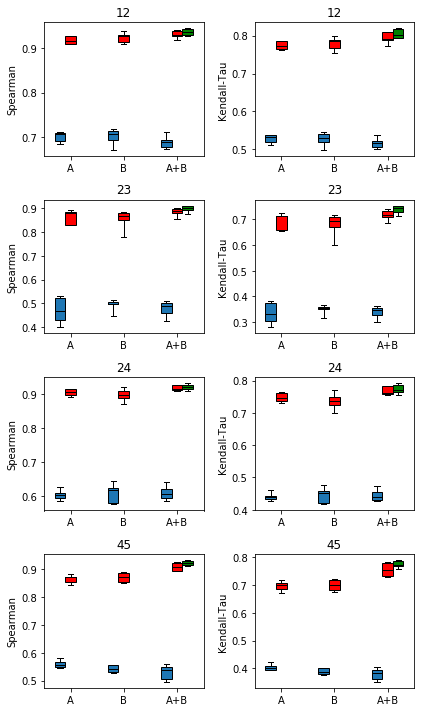

In [76]:
measure_names = ['Spearman','Kendall-Tau']
plt.figure(figsize=(6, 10))
for name, measure in enumerate(['S', 'K']): 
    for row,comparison in enumerate(['12','23','24','45']):
        props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

        #AUC CD$CD*
        ax = plt.subplot(4, 2, row*2+name+1)
        ax.set_ylabel(measure_names[name])
#         ax.set_ylabel(comparison)
        plt.title(comparison)
        bp1 = ax.boxplot([np.abs(edgeR_res[0.0][comparison][x][measure]) for x in ['A','B','AB'] ], positions=[0, 1, 2], **props)
        bp2 = ax.boxplot([scvires['bayes_scanviAB'][comparison][0.0][measure]], positions=[2.4], **props)
        bp3 = ax.boxplot([scvires[x][comparison][0.0][measure] for x in ['bayes_A','bayes_B','bayes_AB']], positions=[0.2, 1.2, 2.2], **props)

        for patch in bp3['boxes']:
            patch.set_facecolor('red')
        for patch in bp2['boxes']:
            patch.set_facecolor('green')

        ax.set_xticklabels(['A','B', 'A+B'])

# ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['edgeR', 'SCANVI', 'scVI'])
plt.tight_layout()
plt.savefig('SIM.DE.pdf')